## This code is part of the final project report submitted for the Data Mining course

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import prophet
# from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')

## Exploratory Data Analysis

In [2]:
import os
import gc
import time
import math
import datetime
from math import log, floor
from sklearn.neighbors import KDTree

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm as tqdm

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

### File 1: “calendar.csv”
##### Contains information about the dates the products are sold.
* date: The date in a “y-m-d” format.
* wm_yr_wk: The id of the week the date belongs to.
* weekday: The type of the day (Saturday, Sunday, …, Friday).
* wday: The id of the weekday, starting from Saturday.
* month: The month of the date.
* year: The year of the date.
* event_name_1: If the date includes an event, the name of this event.
* event_type_1: If the date includes an event, the type of this event.
* event_name_2: If the date includes a second event, the name of this event.
* event_type_2: If the date includes a second event, the type of this event.
* snap_CA, snap_TX, and snap_WI: A binary variable (0 or 1) indicating whether the stores of CA, TX or WI allow SNAP3 purchases on the examined date. 1 indicates that SNAP purchases are allowed.

### File 2: “sell_prices.csv”
#### Contains information about the price of the products sold per store and date.
* store_id: The id of the store where the product is sold.
* item_id: The id of the product.
* wm_yr_wk: The id of the week.
* sell_price: The price of the product for the given week/store. The price is provided per week (average across seven days). If not available, this means that the product was not sold during the examined week. Note that although prices are constant at weekly basis, they may change through time (both training and test set). 

### File 3: “sales_train.csv”
#### Contains the historical daily unit sales data per product and store.
* item_id: The id of the product.
* dept_id: The id of the department the product belongs to.
* cat_id: The id of the category the product belongs to.
* store_id: The id of the store where the product is sold.
* state_id: The State where the store is located.
* d_1, d_2, …, d_i, … d_1941: The number of units sold at day i, starting from 2011-01-29.

In [3]:
# Change INPUT_DIR according to input directory
INPUT_DIR = '/kaggle/input/m5-forecasting-accuracy'
calendar = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
selling_prices = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv')
sample_submission = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')
sales_train_val = pd.read_csv(f'{INPUT_DIR}/sales_train_validation.csv')
sales_train_eval = pd.read_csv(f'{INPUT_DIR}/sales_train_evaluation.csv')

In [4]:
sales_train_val.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd_1',
       'd_2', 'd_3', 'd_4',
       ...
       'd_1904', 'd_1905', 'd_1906', 'd_1907', 'd_1908', 'd_1909', 'd_1910',
       'd_1911', 'd_1912', 'd_1913'],
      dtype='object', length=1919)

In [5]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


## Sales Trends

In [6]:
ids = sorted(list(set(sales_train_val['id'])))
d_cols = [c for c in sales_train_val.columns if 'd_' in c]
x_1 = sales_train_val.loc[sales_train_val['id'] == ids[2]].set_index('id')[d_cols]
x_2 = sales_train_val.loc[sales_train_val['id'] == ids[66]].set_index('id')[d_cols]
x_3 = sales_train_val.loc[sales_train_val['id'] == ids[25]].set_index('id')[d_cols]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_1.values[0])), y=x_1.values[0], showlegend=False,
                    mode='lines', name=x_1.index[0],
                         marker=dict(color="mediumseagreen")),
             row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_2.values[0])), y=x_2.values[0], showlegend=False,
                    mode='lines', name=x_2.index[0],
                         marker=dict(color="violet")),
             row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_3.values[0])), y=x_3.values[0], showlegend=False,
                    mode='lines', name=x_3.index[0],
                         marker=dict(color="dodgerblue")),
             row=3, col=1)

fig.update_layout(height=1200, width=800, title_text="Sample sales")
fig.show()

#### Insights
- The 0 values indicate no sales for that item indicating unavailability
- Spikes may be due to special events

## Visualizing Sample Sales Data

We visualize sample time-series sales data to gain insight into trends, seasonality, or irregularities in the dataset.

In [7]:
ids = sorted(list(set(sales_train_val['id'])))
d_cols = [c for c in sales_train_val.columns if 'd_' in c]
x = sales_train_val.loc[sales_train_val['id'] == ids[2]].set_index('id')[d_cols]
 
fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Scatter(x=np.arange(0, 365), y=x.values[0][0:365], showlegend=False,
                    mode='lines', name=x.index[0],
                         marker=dict(color="mediumseagreen")),
             row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(365, 730), y=x.values[0][365:730], showlegend=False,
                    mode='lines', name=x.index[0],
                         marker=dict(color="mediumseagreen")),
             row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(730, 1095), y=x.values[0][730:1095], showlegend=False,
                    mode='lines', name=x.index[0],
                         marker=dict(color="mediumseagreen")),
             row=3, col=1)

fig.update_layout(height=1200, width=800, title_text="Sample sales for id:2")
fig.show()

## Rolling Average Sales Analysis Per Store

This code computes and visualizes the 90-day rolling average of total sales for each store over time, using time-series data indexed by calendar dates. It highlights trends in sales across different stores, aiding in comparative analysis and identifying seasonal patterns.








In [8]:
past_sales = sales_train_val.set_index('id')[d_cols] \
    .T \
    .merge(calendar.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')

store_list = selling_prices['store_id'].unique()
means = []
fig = go.Figure()
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    data = past_sales[store_items].sum(axis=1).rolling(90).mean()
    means.append(np.mean(past_sales[store_items].sum(axis=1)))
    fig.add_trace(go.Scatter(x=np.arange(len(data)), y=data, name=s))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Time (per store)")

#### Insights
- We can see trends for overall sales per store over the year

## Boxplot of Rolling Average Sales Per Store

Generating a boxplot to visualize the distribution of 90-day rolling average sales for each store. Each box represents the spread of rolling sales averages for a specific store, helping identify differences in sales patterns and variability among stores over time.

In [9]:
fig = go.Figure()

for i, s in enumerate(store_list):
        store_items = [c for c in past_sales.columns if s in c]
        data = past_sales[store_items].sum(axis=1).rolling(90).mean()
        fig.add_trace(go.Box(x=[s]*len(data), y=data, name=s))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Store name ")

### Insights
- The overall sales from California region seem to have a more variance indicating higher growth pace.

# Lets dive into California

## Rolling Average Sales Analysis for California Stores

In [10]:
greens = ["mediumaquamarine", "mediumseagreen", "seagreen", "green"]
store_list = selling_prices['store_id'].unique()
fig = go.Figure()
means = []
stores = []
for i, s in enumerate(store_list):
    if "ca" in s or "CA" in s:
        store_items = [c for c in past_sales.columns if s in c]
        data = past_sales[store_items].sum(axis=1).rolling(90).mean()
        means.append(np.mean(past_sales[store_items].sum(axis=1)))
        stores.append(s)
        fig.add_trace(go.Scatter(x=np.arange(len(data)), y=data, name=s, marker=dict(color=greens[i])))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Time (California)")

#### Insights
- Some hubs in California have more growth than others
- Sales for some increase very slightly
- CA3 has maximum sales

# Lets dive into Texas

## Rolling Average Sales Analysis for Texas Stores

In [11]:
blues = ["skyblue", "dodgerblue", "darkblue"]
store_list = selling_prices['store_id'].unique()
fig = go.Figure()
means = []
stores = []
for i, s in enumerate(store_list):
    if "tx" in s or "TX" in s:
        store_items = [c for c in past_sales.columns if s in c]
        data = past_sales[store_items].sum(axis=1).rolling(90).mean()
        means.append(np.mean(past_sales[store_items].sum(axis=1)))
        stores.append(s)
        fig.add_trace(go.Scatter(x=np.arange(len(data)), y=data, name=s, marker=dict(color=blues[i%len(blues)])))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Time (Texas)")

#### Insights
- Stores in Texas follow a similar pattern for all with low disparity between stores
- The sales trends are also similar
- TX2 has the highest sales but the sales have decreased after a certain period (may be some event happening or other reasons)

# Lets dive into Wisconsin

## Rolling Average Sales Analysis for Wisconsin Stores

In [12]:
purples = ["thistle", "violet", "purple", "indigo"]
store_list = selling_prices['store_id'].unique()
fig = go.Figure()
means = []
stores = []
for i, s in enumerate(store_list):
    if "wi" in s or "WI" in s:
        store_items = [c for c in past_sales.columns if s in c]
        data = past_sales[store_items].sum(axis=1).rolling(90).mean()
        means.append(np.mean(past_sales[store_items].sum(axis=1)))
        stores.append(s)
        fig.add_trace(go.Scatter(x=np.arange(len(data)), y=data, name=s, marker=dict(color=purples[i%len(purples)])))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Time (Wisconsin)")

#### Insights
- The sales between stores show less disparity
- Trend pattern is a bit different from Texas and California
- Sudden jump in sales at a particular period for WI1 and WI2 while sales for WI3 have decreased

## Events

In [13]:
selling_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


## Event Count Calculation for Calendar Data

This code identifies dates in the calendar dataset associated with events and computes an event_count for each date:

2 if both event_name_1 and event_name_2 are present.
1 if only event_name_1 is present.

In [14]:
def event_count(row):
    if pd.notnull(row['event_name_1']) and pd.notnull(row['event_name_2']):
        return 2
    if pd.notnull(row['event_name_1']):
        return 1

event_calendar = calendar[(calendar.event_name_1.notnull())]
event_calendar['event_count'] = event_calendar.apply(event_count, axis=1)
# event_calendar[['d', 'event_count']]
event_calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,event_count
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NaN,NaN,1,1,1,1
16,2011-02-14,11103,Monday,3,2,2011,d_17,ValentinesDay,Cultural,NaN,NaN,0,0,1,1
23,2011-02-21,11104,Monday,3,2,2011,d_24,PresidentsDay,National,NaN,NaN,0,0,0,1
39,2011-03-09,11106,Wednesday,5,3,2011,d_40,LentStart,Religious,NaN,NaN,1,1,1,1
46,2011-03-16,11107,Wednesday,5,3,2011,d_47,LentWeek2,Religious,NaN,NaN,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1926,2016-05-08,11615,Sunday,2,5,2016,d_1927,Mother's day,Cultural,NaN,NaN,1,0,1,1
1948,2016-05-30,11618,Monday,3,5,2016,d_1949,MemorialDay,National,NaN,NaN,0,0,0,1
1951,2016-06-02,11618,Thursday,6,6,2016,d_1952,NBAFinalsStart,Sporting,NaN,NaN,1,0,1,1
1956,2016-06-07,11619,Tuesday,4,6,2016,d_1957,Ramadan starts,Religious,NaN,NaN,1,1,0,1


## Merging Selling Prices with Event Data

Integrating event information with the selling_prices dataset by merging on the wm_yr_wk (week-year) column.

In [15]:
df = pd.merge(selling_prices, event_calendar[['event_name_1', 'event_type_1', 'wm_yr_wk']], how='left', on='wm_yr_wk')
df.groupby(['store_id','item_id','wm_yr_wk']).count()
# df

sell_price  event_name_1  event_type_1
store_id item_id         wm_yr_wk                                        
CA_1     FOODS_1_001     11101              1             0             0
                         11102              1             1             1
                         11103              1             1             1
                         11104              1             1             1
                         11105              1             0             0
...                                       ...           ...           ...
WI_3     HOUSEHOLD_2_516 11617              1             0             0
                         11618              2             2             2
                         11619              1             1             1
                         11620              1             0             0
                         11621              1             1             1

[6841121 rows x 3 columns]

In [16]:
sales_train_val.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [17]:
past_sales.head()

,HOBBIES_1_001_CA_1_validation,HOBBIES_1_002_CA_1_validation,HOBBIES_1_003_CA_1_validation,HOBBIES_1_004_CA_1_validation,HOBBIES_1_005_CA_1_validation,HOBBIES_1_006_CA_1_validation,HOBBIES_1_007_CA_1_validation,HOBBIES_1_008_CA_1_validation,HOBBIES_1_009_CA_1_validation,HOBBIES_1_010_CA_1_validation,...,FOODS_3_818_WI_3_validation,FOODS_3_819_WI_3_validation,FOODS_3_820_WI_3_validation,FOODS_3_821_WI_3_validation,FOODS_3_822_WI_3_validation,FOODS_3_823_WI_3_validation,FOODS_3_824_WI_3_validation,FOODS_3_825_WI_3_validation,FOODS_3_826_WI_3_validation,FOODS_3_827_WI_3_validation
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,0,0,0,0,0,0,0,12,2,0,...,0,14,1,0,4,0,0,0,0,0
2011-01-30,0,0,0,0,0,0,0,15,0,0,...,0,11,1,0,4,0,0,6,0,0
2011-01-31,0,0,0,0,0,0,0,0,7,1,...,0,5,1,0,2,2,0,0,0,0
2011-02-01,0,0,0,0,0,0,0,0,3,0,...,0,6,1,0,5,2,0,2,0,0
2011-02-02,0,0,0,0,0,0,0,0,0,0,...,0,5,1,0,2,0,0,2,0,0


## Per Category Trends

Reshaping the sales data into a long format and aligns it with calendar information for time-series analysis. This transformation prepares the data for merging with the calendar to include actual dates, enabling time-series analysis. The reshaped format is essential for further exploratory data analysis, model training, or forecasting.



In [18]:
sales_df = sales_train_val.set_index('id')
# Melt the sales data to long format
sales_melt = sales_df.melt(id_vars=['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                                  var_name='d', 
                                  value_name='sales')

# Merge with calendar to get the dates
sales_melt['d'] = sales_melt['d'].str.replace('d_', '').astype(int)
calendar1 = calendar.copy()
calendar1['d'] = calendar1['d'].str.replace('d_', '').astype(int)


## Average Sales per Category Over Time

Calculating and visualizing the average sales for each product category over time.

In [19]:
sales_melt = sales_melt.merge(calendar1[['date', 'd']], left_on='d', right_on='d')

# Group by category and date to get average sales
avg_sales_per_category = sales_melt.groupby(['cat_id', 'date'])['sales'].mean().reset_index()

# Plot the data
fig = px.line(avg_sales_per_category, x='date', y='sales', color='cat_id', title='Average Sales per Category')
fig.show()

#### Insights
- Food category has more average sales over time

## Price Distribution by Category

Visualizing the distribution of selling prices for items across different categories using a histogram with boxplots.

In [20]:
selling_prices['Category'] = selling_prices['item_id'].str.split('_', expand=True)[0]

# Plot the distribution of prices per category
fig = px.histogram(selling_prices, x='sell_price', color='Category', 
                   marginal='box', nbins=20, 
                   title='Distribution of Prices per Category', 
                   labels={'sell_price': 'Price'})


## Data Preprocessing

### Downcasting Data Types for Memory Optimization

This function optimizes the memory usage of a DataFrame by downcasting numerical columns to smaller, more efficient data types while ensuring the integrity of the data.

In [21]:
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i, t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == object:  # Use 'object' directly instead of 'np.object'
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df

## Data Loading, Preprocessing, and Feature Engineering for Sales Forecasting

This function processes sales and calendar data, performing tasks such as data cleaning, feature engineering (lag features, rolling mean), and normalization. It prepares the data for modeling.

In [22]:
def load_and_preprocess_data(sales_file, calendar_file):
    # Load data
    df = pd.read_csv(sales_file)
    calendar = pd.read_csv(calendar_file)
    
    # Downcast data types
    df = downcast(df)
    calendar = downcast(calendar)
    
    # Preprocess sales data
    df.drop(columns=['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], inplace=True)
    
    # Transpose and set column names
    data = df.set_index('id').T
    data.index = pd.to_datetime(calendar['date'][:len(data)])  # Set datetime index
    data.index.freq = 'D'  # Set frequency to daily
    
    # Handle missing values (fill with 0 or use forward fill)
    data.fillna(0, inplace=True)

    # Select the product with the highest total sales
    total_sales = data.sum()  # Sum across rows to get total sales per product
    max_sales_product = total_sales.idxmax()
    
    # Add lag features
    for lag in range(1, 8):  # Adding 1 to 7 days lag features
        data[f'lag_{lag}'] = data[max_sales_product].shift(lag)

    # Rolling mean (e.g., 7-day rolling mean)
    data['rolling_mean_7'] = data[max_sales_product].rolling(window=7).mean()

    # Remove rows with NaN values after feature engineering
    data.dropna(inplace=True)

    # Normalize values using Min-Max scaling
    scaler = MinMaxScaler()
    data[max_sales_product] = scaler.fit_transform(data[[max_sales_product]])

    # Optionally normalize lag features and rolling mean if needed
    for lag in range(1, 8):
        data[f'lag_{lag}'] = scaler.fit_transform(data[[f'lag_{lag}']])
    
    data['rolling_mean_7'] = scaler.fit_transform(data[['rolling_mean_7']])

    return data, max_sales_product, calendar  # Return entire data and the name of the max sales product



data, max_sales_product, calendar = load_and_preprocess_data(
    '../input/m5-forecasting-accuracy/sales_train_evaluation.csv',
    '../input/m5-forecasting-accuracy/calendar.csv'
)

# SARIMAX

This code implements a SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors) model to forecast sales data for the product with the highest total sales.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.08922D+00    |proj g|=  2.66772D+00


 This problem is unconstrained.



At iterate    5    f= -1.10758D+00    |proj g|=  3.08298D-01

At iterate   10    f= -1.12446D+00    |proj g|=  1.88175D-01

At iterate   15    f= -1.14289D+00    |proj g|=  9.05648D-01

At iterate   20    f= -1.16075D+00    |proj g|=  7.62508D-02

At iterate   25    f= -1.17451D+00    |proj g|=  7.11842D-02

At iterate   30    f= -1.32535D+00    |proj g|=  1.19126D-01

At iterate   35    f= -1.35795D+00    |proj g|=  8.59701D-01

At iterate   40    f= -1.38025D+00    |proj g|=  1.70796D+00

At iterate   45    f= -1.39925D+00    |proj g|=  3.02492D-01

At iterate   50    f= -1.40572D+00    |proj g|=  9.35318D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

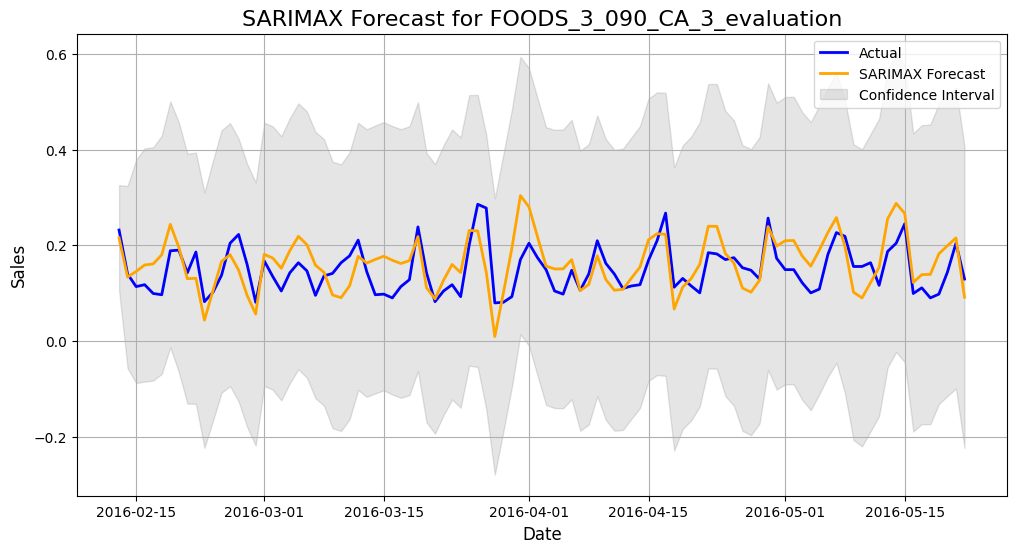

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use the specific product data
sales_data = data[max_sales_product]

# Split into training and test sets
train_sarima = sales_data[:-100]  # Training data (all but last 100)
test_sarima = sales_data[-100:]    # Test data (last 100)

# Prepare exogenous features
exog_train = data[['lag_1', 'lag_2', 'lag_3', 'rolling_mean_7']][:-100]
exog_test = data[['lag_1', 'lag_2', 'lag_3', 'rolling_mean_7']][-100:]

# Fit the SARIMAX model
start_time = time.time()
sarimax_model = SARIMAX(train_sarima, 
                         order=(2, 1, 1), 
                         seasonal_order=(2, 1, 1, 42), 
                         exog=exog_train)
sarimax_fit = sarimax_model.fit()
duration = (time.time() - start_time) / 60
print(f'SARIMAX training completed in: {duration:.2f} minutes')

# Forecast using the fitted model
sarimax_forecast = sarimax_fit.get_forecast(steps=100, exog=exog_test)
sarimax_forecast_mean = sarimax_forecast.predicted_mean
sarimax_conf_int = sarimax_forecast.conf_int()

# Calculate RMSE
sarimax_rmse = np.sqrt(mean_squared_error(test_sarima, sarimax_forecast_mean))
print(f'SARIMAX RMSE: {sarimax_rmse:.2f}')

# Plotting results
plt.figure(figsize=(12, 6))
plt.plot(test_sarima.index, test_sarima, label='Actual', color='blue', linewidth=2)
plt.plot(test_sarima.index, sarimax_forecast_mean, label='SARIMAX Forecast', color='orange', linewidth=2)
plt.fill_between(test_sarima.index, 
                 sarimax_conf_int.iloc[:, 0], 
                 sarimax_conf_int.iloc[:, 1], 
                 color='k', alpha=0.1, label='Confidence Interval')
plt.title(f'SARIMAX Forecast for {max_sales_product}', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

## Data Preparation for Time Series Analysis

This function would give you insights into the time series' stationarity, trends, seasonality, and autocorrelation patterns, which are essential when building time series models like ARIMA or SARIMAX. If you notice non-stationarity, you might need to difference the data or apply transformations before fitting models.

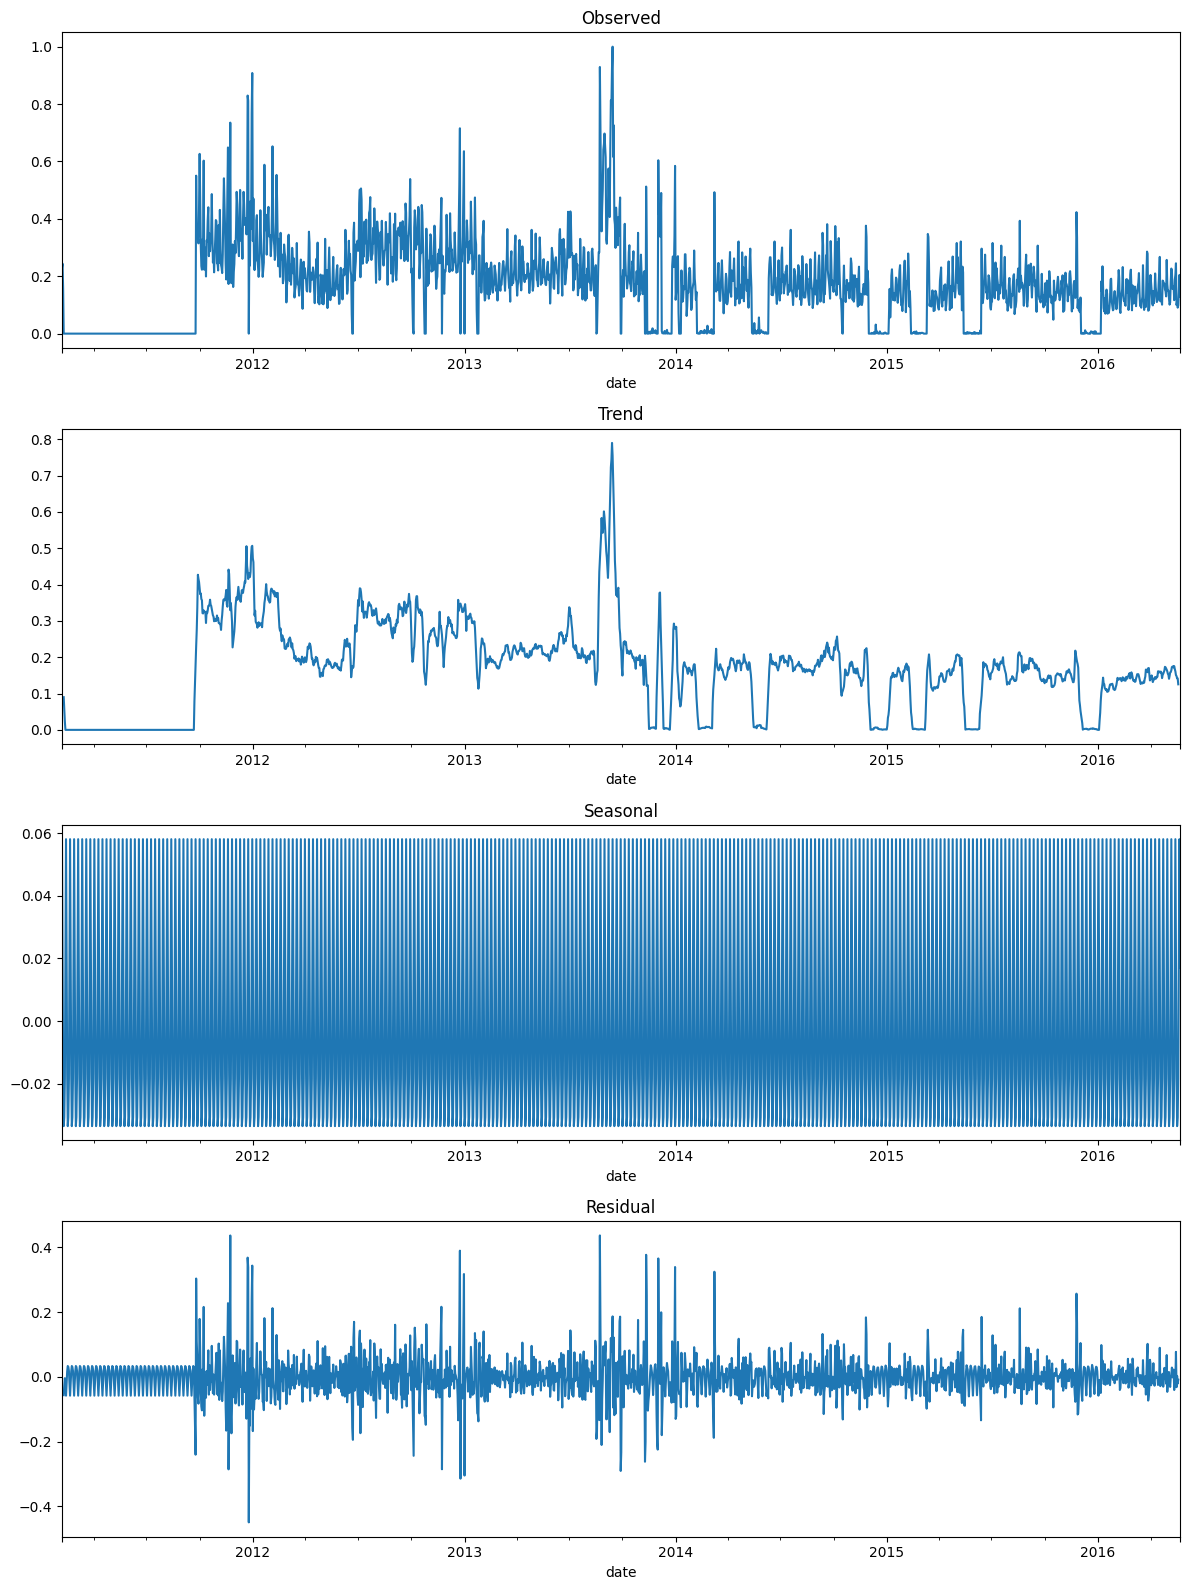

ADF Statistic: -4.227336106736276
p-value: 0.0005921063508314324
Critical Values: {'1%': -3.4337801282776335, '5%': -2.8630552063395585, '10%': -2.5675766377428086}


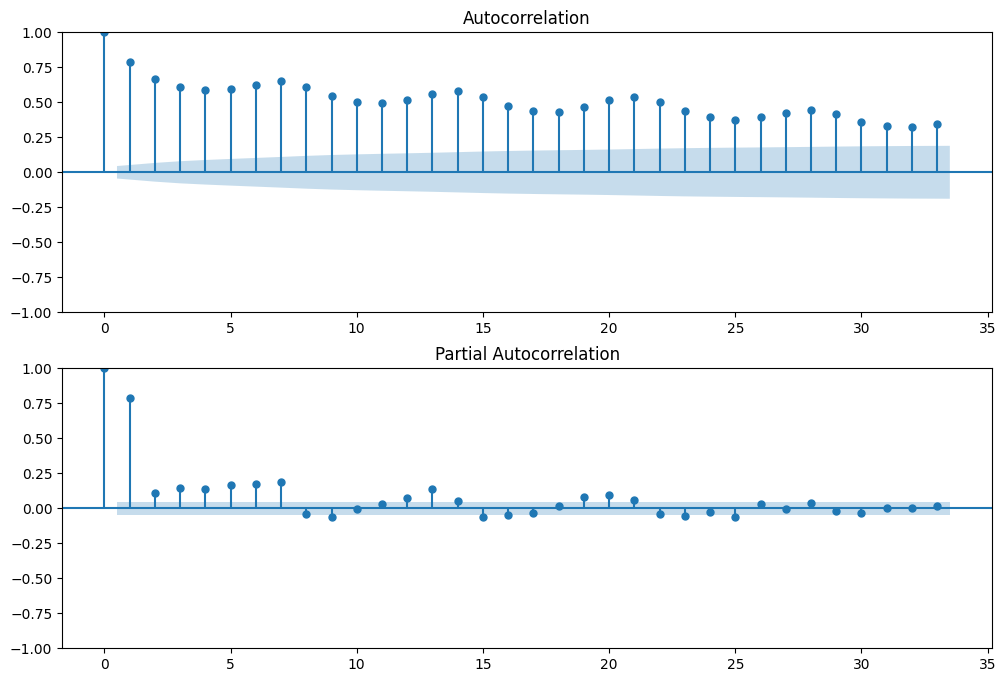

In [24]:
def analyze_time_series(data):
    # Decompose the time series
    decomposition = seasonal_decompose(data, model='additive')
    
    # Plot decomposition
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 16))
    decomposition.observed.plot(ax=ax1)
    ax1.set_title('Observed')
    decomposition.trend.plot(ax=ax2)
    ax2.set_title('Trend')
    decomposition.seasonal.plot(ax=ax3)
    ax3.set_title('Seasonal')
    decomposition.resid.plot(ax=ax4)
    ax4.set_title('Residual')
    plt.tight_layout()
    plt.show()
    
    # Perform ADF test
    result = adfuller(data.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    
    # Plot ACF and PACF
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(data, ax=ax1)
    plot_pacf(data, ax=ax2)
    plt.show()

# Usage
analyze_time_series(sales_data)

## SARIMA Model

The code fits a SARIMA model to a time series dataset by first splitting the data into training and test sets, then using the SARIMAX model to forecast future values based on specified ARIMA and seasonal orders. It evaluates the model's performance by calculating the RMSE and visualizes the forecasted values alongside the actual values and confidence intervals.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.74284D-01    |proj g|=  2.48515D+00


 This problem is unconstrained.



At iterate    5    f= -9.00200D-01    |proj g|=  1.30626D-01

At iterate   10    f= -9.08621D-01    |proj g|=  2.53127D-01

At iterate   15    f= -9.14282D-01    |proj g|=  2.72075D-01

At iterate   20    f= -9.30784D-01    |proj g|=  1.82620D+00

At iterate   25    f= -9.63321D-01    |proj g|=  2.46536D-01

At iterate   30    f= -9.78598D-01    |proj g|=  2.58438D-01

At iterate   35    f= -9.79836D-01    |proj g|=  2.27535D-02

At iterate   40    f= -9.79869D-01    |proj g|=  2.47563D-03

At iterate   45    f= -9.79871D-01    |proj g|=  1.41137D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     48     59   

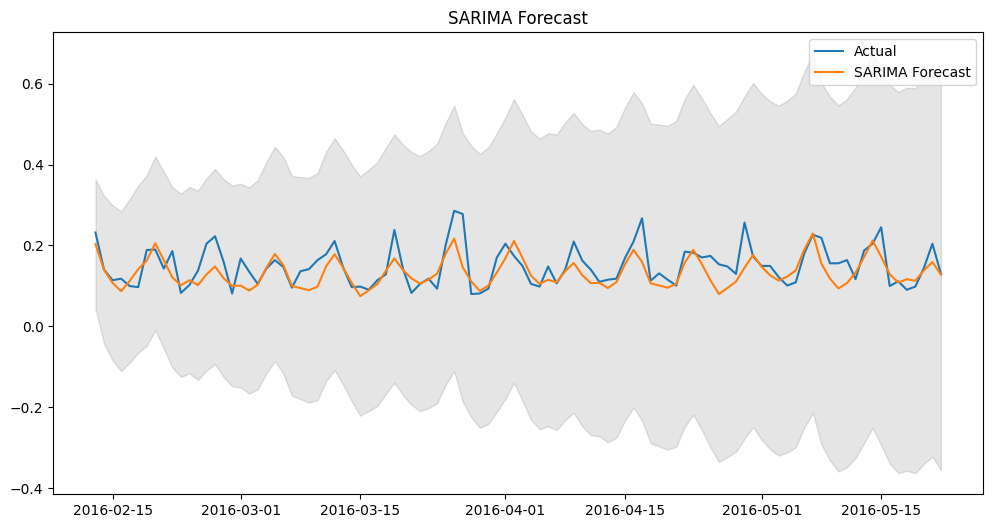

In [25]:
def fit_sarima_model(train, order, seasonal_order):
    model = sm.tsa.statespace.SARIMAX(train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit()
    return results

def forecast_sarima(model, steps):
    forecast = model.get_forecast(steps=steps)
    return forecast.predicted_mean, forecast.conf_int()

# Usage
sales_data = pd.to_numeric(sales_data, errors='coerce')

train_sarima = sales_data[:-100]
test_sarima = sales_data[-100:]

# train_sarima = pd.to_numeric(sales_data, errors='coerce')
# test_sarima = pd.to_numeric(sales_data, errors='coerce')

start_time = time.time()
sarima_model = fit_sarima_model(train_sarima, order=(2, 1, 1), seasonal_order=(2, 1, 1, 42))
duration = (time.time() - start_time) / 60
print(f'SARIMA training completed in: {duration:.2f} minutes')

sarima_forecast, sarima_conf_int = forecast_sarima(sarima_model, steps=100)

# Calculate RMSE
sarima_rmse = np.sqrt(mean_squared_error(test_sarima, sarima_forecast))
print(f'SARIMA RMSE: {sarima_rmse:.2f}')

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test_sarima.index, test_sarima, label='Actual')
plt.plot(test_sarima.index, sarima_forecast, label='SARIMA Forecast')
plt.fill_between(test_sarima.index, sarima_conf_int.iloc[:, 0], sarima_conf_int.iloc[:, 1], color='k', alpha=0.1)
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

## LSTM Model

The below code prepares a time series dataset by scaling the data, then creates sequences of data for training an LSTM model to forecast future sales. It trains the model on the prepared sequences, makes forecasts, calculates the RMSE to evaluate performance, and visualizes the actual vs. forecasted values.

I0000 00:00:1732580383.872949      68 service.cc:145] XLA service 0x7a51e8007eb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732580383.873013      68 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1732580384.820616      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


LSTM training completed in: 0.35 minutes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━

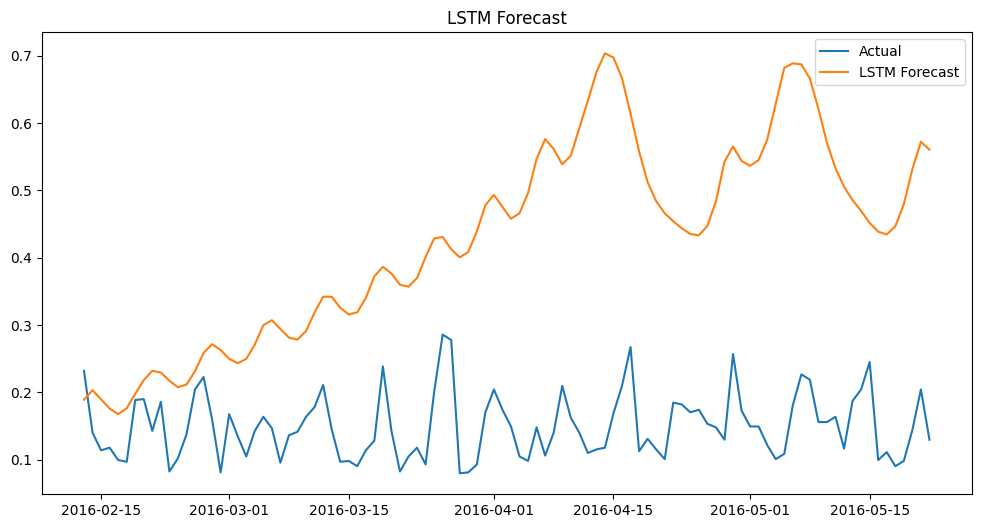

In [26]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Prepare data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(sales_data.values.reshape(-1, 1))

seq_length = 12
x_train, y_train = create_sequences(scaled_data[:-100], seq_length)
x_test, y_test = create_sequences(scaled_data[-100-seq_length:], seq_length)

# Train LSTM model
start_time = time.time()
lstm_model = create_lstm_model((seq_length, 1))
lstm_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=0)
duration = (time.time() - start_time) / 60
print(f'LSTM training completed in: {duration:.2f} minutes')

# Forecast using LSTM
lstm_forecast = []
last_sequence = x_test[0]
for _ in range(100):
    next_pred = lstm_model.predict(last_sequence.reshape(1, seq_length, 1))[0, 0]
    lstm_forecast.append(next_pred)
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = next_pred

lstm_forecast = scaler.inverse_transform(np.array(lstm_forecast).reshape(-1, 1)).flatten()

# Calculate RMSE
lstm_rmse = np.sqrt(mean_squared_error(test_sarima, lstm_forecast))
print(f'LSTM RMSE: {lstm_rmse:.2f}')

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test_sarima.index, test_sarima, label='Actual')
plt.plot(test_sarima.index, lstm_forecast, label='LSTM Forecast')
plt.title('LSTM Forecast')
plt.legend()
plt.show()

In [27]:
test_sarima.shape

(100,)

In [28]:
y_test.shape

(100, 1)

In [29]:
lstm_forecast.shape

(100,)

## Prophet Model

This code below prepares the sales data for use with the Prophet model, which includes creating holiday information from a calendar and converting the data into a format suitable for Prophet. It then trains a Prophet model on the training data, forecasts future sales, evaluates the model using RMSE, and visualizes the actual vs. forecasted sales values.

00:20:09 - cmdstanpy - INFO - Chain [1] start processing
00:20:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet training completed in: 0.01 minutes
Prophet RMSE: 0.10


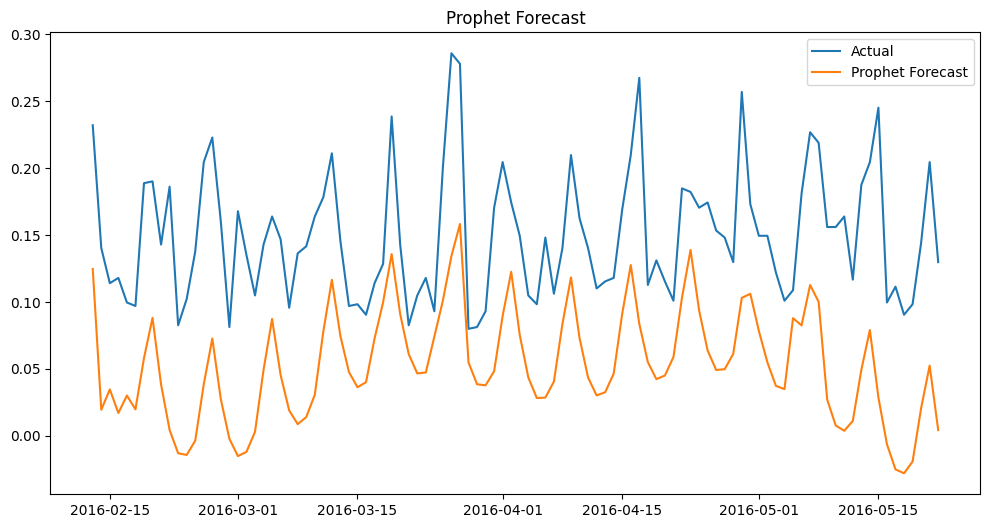

In [30]:
def prepare_prophet_data(data, calendar):
    prophet_data = pd.DataFrame({'ds': data.index, 'y': data.values})
    holidays = calendar[calendar['event_type_1'].notnull()][['date', 'event_name_1']]
    holidays.columns = ['ds', 'holiday']
    holidays['ds'] = pd.to_datetime(holidays['ds'])
    return prophet_data, holidays

def fit_prophet_model(data, holidays):
    model = prophet.Prophet(holidays=holidays, weekly_seasonality=True)
    model.fit(data)
    return model

def forecast_prophet(model, periods):
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    return forecast

# Prepare data for Prophet
prophet_data, holidays = prepare_prophet_data(sales_data, calendar)
train_prophet = prophet_data[:-100]
test_prophet = prophet_data[-100:]

# Train Prophet model
start_time = time.time()
prophet_model = fit_prophet_model(train_prophet, holidays)
duration = (time.time() - start_time) / 60
print(f'Prophet training completed in: {duration:.2f} minutes')

# Forecast using Prophet
prophet_forecast = forecast_prophet(prophet_model, periods=100)
prophet_forecast = prophet_forecast.iloc[-100:]['yhat']

# Calculate RMSE
prophet_rmse = np.sqrt(mean_squared_error(test_prophet['y'], prophet_forecast))
print(f'Prophet RMSE: {prophet_rmse:.2f}')

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test_prophet['ds'], test_prophet['y'], label='Actual')
plt.plot(test_prophet['ds'], prophet_forecast, label='Prophet Forecast')
plt.title('Prophet Forecast')
plt.legend()
plt.show()

## Model Comparison

We finally compare the performance of three forecasting models (SARIMA, LSTM, and Prophet) by calculating their RMSE values against the actual test data, and then visualizes the forecasted values from each model alongside the actual sales data. It provides a direct comparison of how well each model performs in terms of forecasting accuracy.

SARIMA RMSE: 0.04
LSTM RMSE: 0.31
Prophet RMSE: 0.10


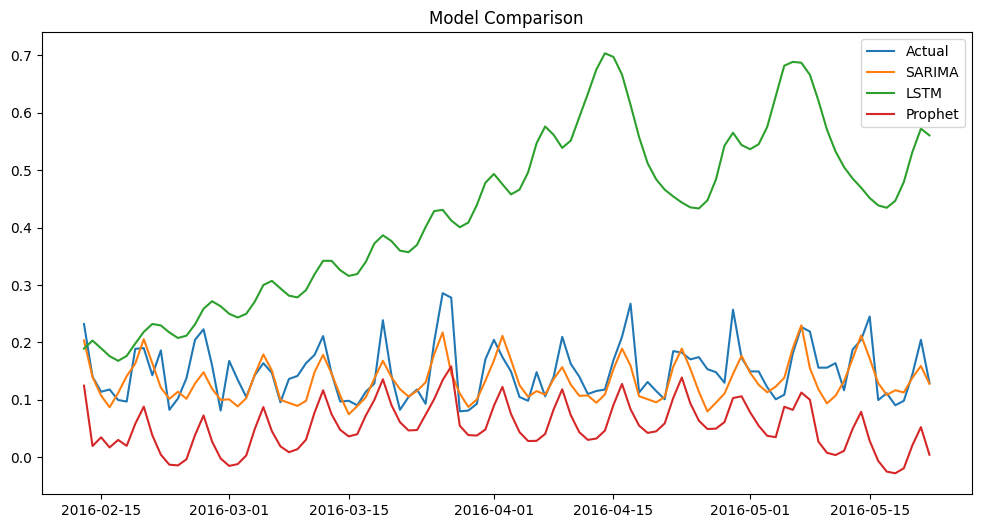

In [31]:
def compare_models(actual, sarima_forecast, lstm_forecast, prophet_forecast):
    sarima_rmse = np.sqrt(mean_squared_error(actual, sarima_forecast))
    lstm_rmse = np.sqrt(mean_squared_error(actual, lstm_forecast))
    prophet_rmse = np.sqrt(mean_squared_error(actual, prophet_forecast))
    
    print(f'SARIMA RMSE: {sarima_rmse:.2f}')
    print(f'LSTM RMSE: {lstm_rmse:.2f}')
    print(f'Prophet RMSE: {prophet_rmse:.2f}')
    
    plt.figure(figsize=(12, 6))
    plt.plot(actual.index, actual, label='Actual')
    plt.plot(actual.index, sarima_forecast, label='SARIMA')
    plt.plot(actual.index, lstm_forecast, label='LSTM')
    plt.plot(actual.index, prophet_forecast, label='Prophet')
    plt.title('Model Comparison')
    plt.legend()
    plt.show()

# Usage
compare_models(test_sarima, sarima_forecast, lstm_forecast, prophet_forecast)